In [ ]:
# ======================================================
# CELL 0
# INSTALL DEPENDENCY (COMPATIBLE DENGAN COLAB 2025)
# ======================================================

!pip install -q gdown
!pip install -q transformers datasets
!pip install -q scikit-learn matplotlib


# ---------- BASIC ----------
import os
import re
import numpy as np
import pandas as pd

# ---------- VISUALIZATION ----------
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- MACHINE LEARNING ----------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ---------- TENSORFLOW / KERAS ----------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---------- HUGGINGFACE ----------
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertForSequenceClassification,
    BertTokenizerFast,
    TFBertForSequenceClassification
)

# ---------- DATA DOWNLOAD ----------
import gdown


import warnings

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="huggingface_hub"
)


In [ ]:
import tensorflow as tf
import transformers
import datasets

print("TensorFlow :", tf.__version__)
print("Transformers :", transformers.__version__)
print("Datasets :", datasets.__version__)


TensorFlow : 2.19.0
Transformers : 4.57.3
Datasets : 4.0.0


In [ ]:
# ======================================================
# CELL 2
# DOWNLOAD DATASET DARI GOOGLE DRIVE
# ======================================================
# Dataset diambil menggunakan gdown (tanpa mount manual)
# File ini nantinya bisa ikut di-push ke GitHub

DATASET_ID = "1i49vvapRxlXCyubdEoDyZqOlfvnDaw73"
OUTPUT_FILE = "Tweets.csv"

if not os.path.exists(OUTPUT_FILE):
    gdown.download(
        f"https://drive.google.com/uc?id={DATASET_ID}",
        OUTPUT_FILE,
        quiet=False
    )

print("Dataset siap digunakan:", OUTPUT_FILE)


Dataset siap digunakan: Tweets.csv


In [ ]:
# ======================================================
# DATASET KHUSUS PRETRAINED (DISTILBERT & BERT)
# ======================================================
df_bert = df.copy()
df_bert["text"] = df_bert["text"].astype(str)


In [ ]:
# ======================================================
# CELL 3 (FINAL & FIXED)
# LOAD DATASET DENGAN DELIMITER YANG BENAR
# ======================================================

df = pd.read_csv(
    "Tweets.csv",
    sep=";",              # ⬅️ PENTING: delimiter SEMICOLON
    engine="python",
    encoding="utf-8",
    on_bad_lines="skip"
)

print("Nama kolom dataset:")
print(df.columns)

print("\nContoh data:")
df.head()


Nama kolom dataset:
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

Contoh data:


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,"5,70E+17",neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0.0,@VirginAmerica What @dhepburn said.,NaN,24/02/2015 11:35,NaN,Eastern Time (US & Canada)
1,"5,70E+17",positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica plus you've added commercials t...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada)
2,"5,70E+17",neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0.0,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/2015 11:15,Lets Play,Central Time (US & Canada)
3,"5,70E+17",negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica it's really aggressive to blast...,NaN,NaN,NaN,NaN
4,"5,70E+17",negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica and it's a really big bad thing...,NaN,24/02/2015 11:14,NaN,Pacific Time (US & Canada)


In [ ]:
# ======================================================
# CELL 4
# AMBIL KOLOM TEKS & LABEL
# ======================================================

df = df[['text', 'airline_sentiment']]
df.columns = ['text', 'label']

df['label'] = df['label'].str.lower()

label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

df['label'] = df['label'].map(label_mapping)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

print("Jumlah data:", len(df))
df.head()


Jumlah data: 14616


,text,label
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [ ]:
# ======================================================
# PREPROCESSING TEKS DENGAN VALIDASI DATA
# ======================================================

df = df.dropna(subset=['text'])
df['text'] = df['text'].astype(str)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)   # hapus URL
    text = re.sub(r"@\w+", "", text)      # hapus mention
    text = re.sub(r"[^a-z\s]", "", text)  # hapus simbol & angka
    text = re.sub(r"\s+", " ", text)      # rapikan spasi
    return text.strip()

# Terapkan preprocessing
df_lstm = df.copy()
df_lstm["text"] = df_lstm["text"].apply(clean_text)

# SIMPAN HASIL PREPROCESSING (INI YANG PENTING)
df_lstm.to_csv("clean_tweets.csv", index=False)

print("Preprocessing selesai. Jumlah data:", len(df_lstm))
df_lstm.head()


Preprocessing selesai. Jumlah data: 14608


,text,label
0,what said,1
1,plus youve added commercials to the experience...,2
2,i didnt today must mean i need to take another...,1
3,its really aggressive to blast obnoxious enter...,0
4,and its a really big bad thing about it,0


#Anlisis Dataset

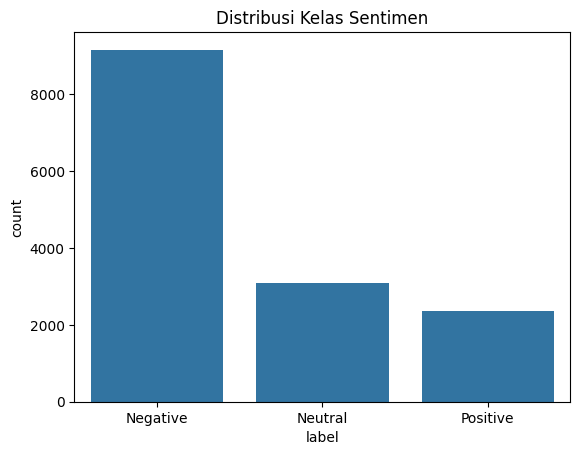

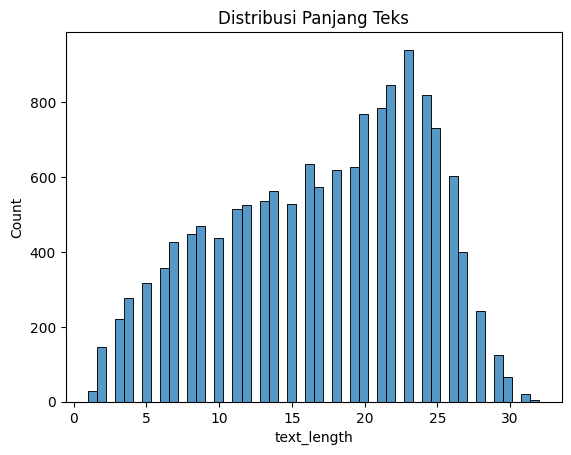

In [ ]:
# Distribusi kelas
sns.countplot(x=df['label'])
plt.xticks([0,1,2], ['Negative', 'Neutral', 'Positive'])
plt.title("Distribusi Kelas Sentimen")
plt.show()

# Panjang teks
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=50)
plt.title("Distribusi Panjang Teks")
plt.show()


In [ ]:
# ======================================================
# CELL 7
# SPLIT DATA TRAIN & TEST
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


#MODEL 1 — NEURAL NETWORK NON-PRETRAINED (LSTM)

In [ ]:
tokenizer_lstm = Tokenizer(num_words=10000)
tokenizer_lstm.fit_on_texts(X_train)

X_train_seq = pad_sequences(
    tokenizer_lstm.texts_to_sequences(X_train),
    maxlen=100
)

X_test_seq = pad_sequences(
    tokenizer_lstm.texts_to_sequences(X_test),
    maxlen=100
)


In [ ]:
lstm_model = Sequential([
    Embedding(10000, 128),
    LSTM(128),
    Dense(3, activation='softmax')
])

lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lstm = lstm_model.fit(
    X_train_seq,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6493 - loss: 0.8345 - val_accuracy: 0.7571 - val_loss: 0.5911
Epoch 2/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8274 - loss: 0.4510 - val_accuracy: 0.7742 - val_loss: 0.5930
Epoch 3/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8864 - loss: 0.3088 - val_accuracy: 0.7656 - val_loss: 0.6816
Epoch 4/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9196 - loss: 0.2235 - val_accuracy: 0.7382 - val_loss: 0.8094
Epoch 5/5
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9372 - loss: 0.1724 - val_accuracy: 0.7382 - val_loss: 0.8852


In [ ]:
# ======================================================
# CELL
# PREDIKSI MODEL LSTM
# ======================================================

# Melakukan prediksi pada data test
y_pred_lstm = np.argmax(
    lstm_model.predict(X_test_seq),
    axis=1
)

print("Prediksi LSTM selesai")


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Prediksi LSTM selesai


In [ ]:
print("=== LSTM Classification Report ===")
print(
    classification_report(
        y_test,
        y_pred_lstm,
        target_names=["Negative", "Neutral", "Positive"],
        zero_division=0
    )
)


=== LSTM Classification Report ===
              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85      1831
     Neutral       0.59      0.58      0.58       619
    Positive       0.65      0.71      0.68       472

    accuracy                           0.77      2922
   macro avg       0.70      0.71      0.71      2922
weighted avg       0.77      0.77      0.77      2922



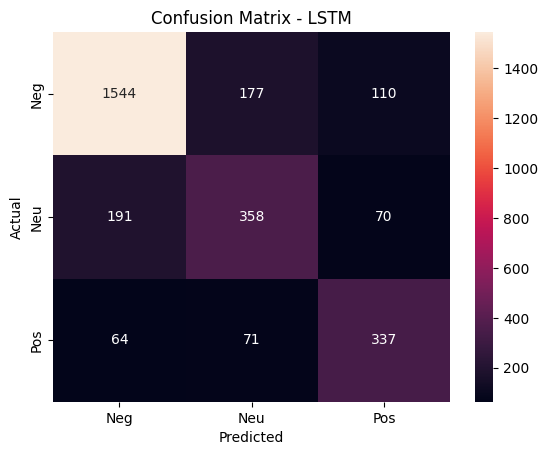

In [ ]:
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

sns.heatmap(
    cm_lstm,
    annot=True,
    fmt="d",
    xticklabels=["Neg", "Neu", "Pos"],
    yticklabels=["Neg", "Neu", "Pos"]
)

plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


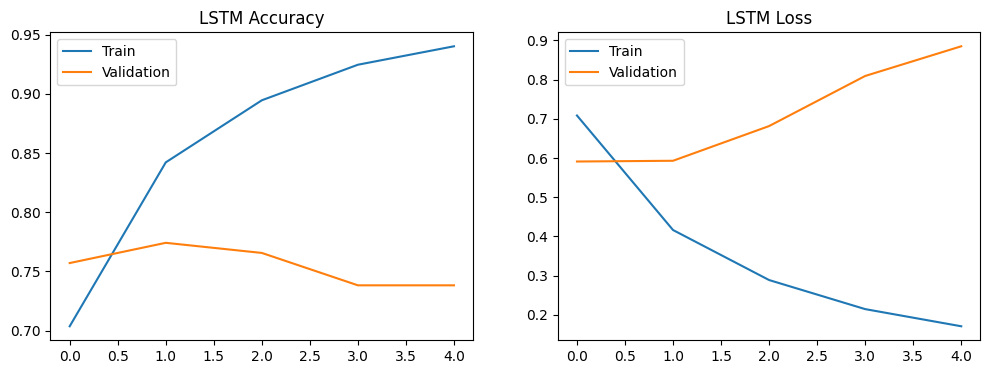

In [ ]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_lstm.history["accuracy"], label="Train")
plt.plot(history_lstm.history["val_accuracy"], label="Validation")
plt.title("LSTM Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_lstm.history["loss"], label="Train")
plt.plot(history_lstm.history["val_loss"], label="Validation")
plt.title("LSTM Loss")
plt.legend()

plt.show()


#MODEL 2 — PRETRAINED (DISTILBERT)

In [ ]:
!pip install -q torch accelerate


In [ ]:
# ======================================================
# CELL 2
# DATASET DISTILBERT (PRETRAINED MODEL)
# ======================================================

df_bert = df.copy()
df_bert["text"] = df_bert["text"].astype(str)

dataset_distil = Dataset.from_pandas(df_bert)

dataset_distil = dataset_distil.train_test_split(
    test_size=0.2,
    seed=42
)

# Hapus kolom index otomatis & fitur yang tidak digunakan
dataset_distil = dataset_distil.remove_columns(
    [col for col in ["__index_level_0__", "text_length"] if col in dataset_distil["train"].column_names]
)

print(dataset_distil)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11686
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2922
    })
})


In [ ]:
# ======================================================
# CELL 3
# TOKENIZATION TEKS UNTUK DISTILBERT
# ======================================================

tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset_distil = dataset_distil.map(
    tokenize_function,
    batched=True
)

# DistilBERT tidak membutuhkan kolom teks mentah setelah tokenisasi
dataset_distil = dataset_distil.remove_columns(["text"])

# Format dataset ke PyTorch tensor
dataset_distil.set_format("torch")


Map:   0%|          | 0/11686 [00:00<?, ? examples/s]

Map:   0%|          | 0/2922 [00:00<?, ? examples/s]

In [ ]:
# ======================================================
# CELL 4
# LOAD PRETRAINED DISTILBERT
# ======================================================
# Model pretrained dari HuggingFace
# Layer classifier diinisialisasi ulang (TRANSFER LEARNING)
from transformers import DistilBertForSequenceClassification

model_distil = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ======================================================
# CELL 5
# KONFIGURASI TRAINING DISTILBERT
# ======================================================
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./distilbert_output",

    # Jumlah epoch fine-tuning
    num_train_epochs=5,

    # Batch size training dan evaluasi
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    # Strategi evaluasi (VERSI BARU)
    eval_strategy="epoch",

    # Strategi logging dan penyimpanan
    logging_strategy="epoch",
    save_strategy="no",

    # Learning rate kecil (standar BERT / DistilBERT)
    learning_rate=2e-5,

    # Nonaktifkan logging ke layanan eksternal
    report_to="none"
)


In [ ]:
# ======================================================
# CELL 5B
# METRIC UNTUK ACCURACY (WAJIB UNTUK GRAFIK ACC)
# ======================================================

from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }


In [ ]:
# ======================================================
# CELL 6
# TRAINING DISTILBERT (TRANSFER LEARNING + ACCURACY)
# ======================================================

from transformers import Trainer

trainer = Trainer(
    model=model_distil,
    args=training_args,
    train_dataset=dataset_distil["train"],
    eval_dataset=dataset_distil["test"],
    compute_metrics=compute_metrics   # 🔥 INI YANG DITAMBAHKAN
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.534600,0.430537,0.833676
2,0.351300,0.423335,0.839493
3,0.238800,0.549780,0.839151
4,0.161800,0.641645,0.839836
5,0.115800,0.692485,0.843258


TrainOutput(global_step=3655, training_loss=0.2804600038541489, metrics={'train_runtime': 671.1072, 'train_samples_per_second': 87.065, 'train_steps_per_second': 5.446, 'total_flos': 1935052034158080.0, 'train_loss': 0.2804600038541489, 'epoch': 5.0})

In [ ]:
# ======================================================
# CELL 7
# CLASSIFICATION REPORT DISTILBERT
# ======================================================

pred = trainer.predict(dataset_distil["test"])

y_pred_distil = np.argmax(pred.predictions, axis=1)
y_true_distil = pred.label_ids

print("=== DistilBERT Classification Report ===")
print(
    classification_report(
        y_true_distil,
        y_pred_distil,
        target_names=["Negative", "Neutral", "Positive"],
        zero_division=0
    )
)


=== DistilBERT Classification Report ===
              precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      1864
     Neutral       0.70      0.64      0.67       583
    Positive       0.79      0.81      0.80       475

    accuracy                           0.84      2922
   macro avg       0.80      0.79      0.79      2922
weighted avg       0.84      0.84      0.84      2922



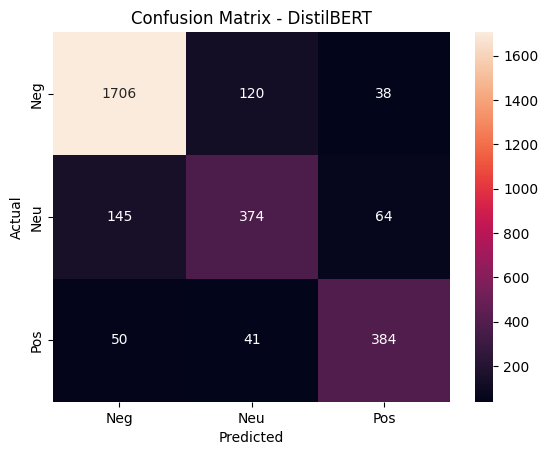

In [ ]:
# ======================================================
# CELL 8
# CONFUSION MATRIX DISTILBERT
# ======================================================

cm_distil = confusion_matrix(y_true_distil, y_pred_distil)

sns.heatmap(
    cm_distil,
    annot=True,
    fmt="d",
    xticklabels=["Neg","Neu","Pos"],
    yticklabels=["Neg","Neu","Pos"]
)

plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


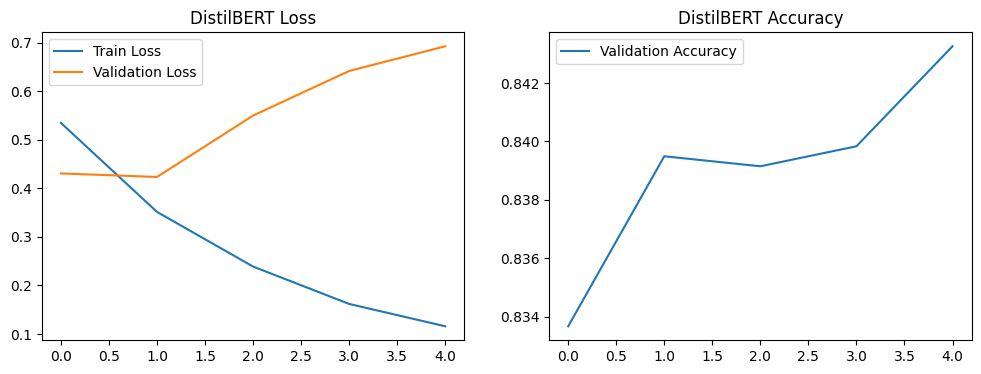

In [ ]:
# ======================================================
# GRAFIK LOSS & ACCURACY DISTILBERT
# ======================================================

logs = trainer.state.log_history

train_loss = [x["loss"] for x in logs if "loss" in x]
eval_loss  = [x["eval_loss"] for x in logs if "eval_loss" in x]
eval_acc   = [x["eval_accuracy"] for x in logs if "eval_accuracy" in x]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.title("DistilBERT Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(eval_acc, label="Validation Accuracy")
plt.title("DistilBERT Accuracy")
plt.legend()

plt.show()


#PRETRAINED MODEL 2 — BERT

In [ ]:
# ======================================================
# CELL 1
# DATASET BERT (TEKS ASLI, TANPA PREPROCESSING AGRESIF)
# ======================================================

from datasets import Dataset

df_bert = df.copy()

# Pastikan teks bertipe string
df_bert["text"] = df_bert["text"].astype(str)

dataset_bert = Dataset.from_pandas(df_bert)

dataset_bert = dataset_bert.train_test_split(
    test_size=0.2,
    seed=42
)

# Hapus kolom index otomatis jika ada
dataset_bert = dataset_bert.remove_columns(
    [c for c in ["__index_level_0__", "text_length"] if c in dataset_bert["train"].column_names]
)

print(dataset_bert)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11686
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2922
    })
})


In [ ]:
# ======================================================
# CELL 2
# TOKENIZATION UNTUK BERT
# ======================================================

from transformers import BertTokenizerFast

tokenizer_bert = BertTokenizerFast.from_pretrained(
    "bert-base-uncased"
)

def tokenize_bert(batch):
    return tokenizer_bert(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset_bert = dataset_bert.map(
    tokenize_bert,
    batched=True
)

# Hapus teks mentah setelah tokenisasi
dataset_bert = dataset_bert.remove_columns(["text"])

# Set format ke PyTorch tensor
dataset_bert.set_format("torch")


Map:   0%|          | 0/11686 [00:00<?, ? examples/s]

Map:   0%|          | 0/2922 [00:00<?, ? examples/s]

In [ ]:
# ======================================================
# CELL 3
# INISIALISASI MODEL PRETRAINED BERT
# ======================================================

from transformers import BertForSequenceClassification

model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ======================================================
# CELL 4
# KONFIGURASI TRAINING BERT
# ======================================================

from transformers import TrainingArguments

args_bert = TrainingArguments(
    output_dir="./bert_output",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    report_to="none"
)


In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": (preds == labels).mean()
    }


In [ ]:
# ======================================================
# CELL 5
# TRAINING MODEL BERT (FINE-TUNING)
# ======================================================

from transformers import Trainer

trainer_bert = Trainer(
    model=model_bert,
    args=args_bert,
    train_dataset=dataset_bert["train"],
    eval_dataset=dataset_bert["test"],
    compute_metrics=compute_metrics
)

trainer_bert.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.509000,0.432182,0.829569
2,0.318300,0.435486,0.843943
3,0.193700,0.631940,0.849076
4,0.115300,0.741326,0.843258
5,0.075400,0.797854,0.842574


TrainOutput(global_step=3655, training_loss=0.2423402736679474, metrics={'train_runtime': 1334.6871, 'train_samples_per_second': 43.778, 'train_steps_per_second': 2.738, 'total_flos': 3843429249461760.0, 'train_loss': 0.2423402736679474, 'epoch': 5.0})

In [ ]:
# ======================================================
# CELL 6
# PREDIKSI MODEL BERT
# ======================================================

import numpy as np

pred_bert = trainer_bert.predict(dataset_bert["test"])

y_pred_bert = np.argmax(pred_bert.predictions, axis=1)
y_true_bert = pred_bert.label_ids


In [ ]:
# ======================================================
# CELL 7
# CLASSIFICATION REPORT BERT
# ======================================================

from sklearn.metrics import classification_report

print("=== BERT Classification Report ===")
print(
    classification_report(
        y_true_bert,
        y_pred_bert,
        target_names=["Negative", "Neutral", "Positive"],
        zero_division=0
    )
)


=== BERT Classification Report ===
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.90      1864
     Neutral       0.69      0.65      0.67       583
    Positive       0.79      0.83      0.81       475

    accuracy                           0.84      2922
   macro avg       0.79      0.80      0.79      2922
weighted avg       0.84      0.84      0.84      2922



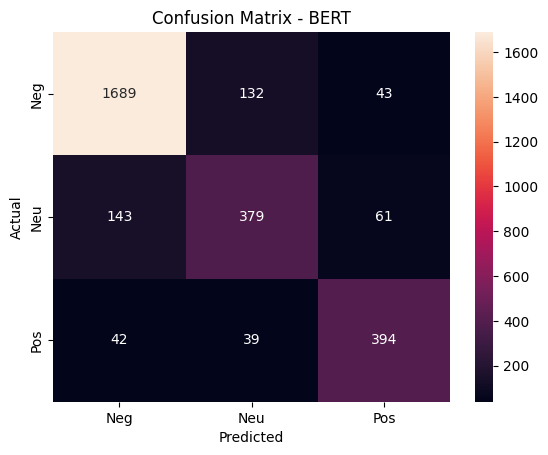

In [ ]:
# ======================================================
# CELL 8
# CONFUSION MATRIX BERT
# ======================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_bert = confusion_matrix(y_true_bert, y_pred_bert)

sns.heatmap(
    cm_bert,
    annot=True,
    fmt="d",
    xticklabels=["Neg", "Neu", "Pos"],
    yticklabels=["Neg", "Neu", "Pos"]
)

plt.title("Confusion Matrix - BERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


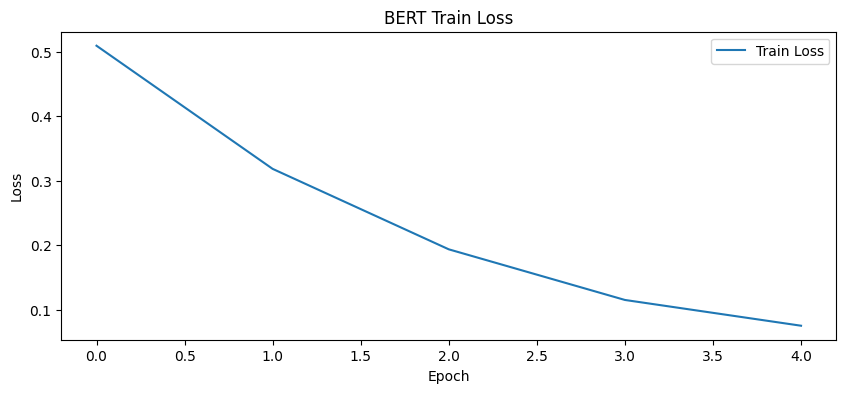

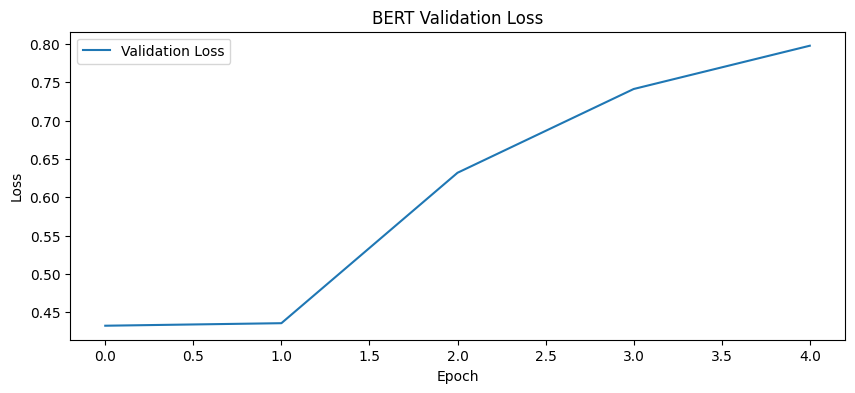

In [ ]:
# ======================================================
# CELL 9
# GRAFIK LOSS TRAINING BERT
# ======================================================

logs_bert = trainer_bert.state.log_history

train_loss_bert = [x["loss"] for x in logs_bert if "loss" in x]
eval_loss_bert  = [x["eval_loss"] for x in logs_bert if "eval_loss" in x]

# Gambar 1 - Train Loss
plt.figure(figsize=(10,4))
plt.plot(train_loss_bert, label="Train Loss")
plt.title("BERT Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Gambar 2 - Validation Loss
plt.figure(figsize=(10,4))
plt.plot(eval_loss_bert, label="Validation Loss")
plt.title("BERT Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


#Model

In [ ]:
# ===============================
# SIMPAN MODEL LSTM & TOKENIZER
# ===============================
import pickle

lstm_model.save("lstm_model.h5")

with open("tokenizer_lstm.pkl", "wb") as f:
    pickle.dump(tokenizer_lstm, f)


In [ ]:
model_distil.save_pretrained("bert_models/distilbert")
tokenizer.save_pretrained("bert_models/distilbert")

model_bert.save_pretrained("bert_models/bert")
tokenizer_bert.save_pretrained("bert_models/bert")


('bert_models/bert/tokenizer_config.json',
 'bert_models/bert/special_tokens_map.json',
 'bert_models/bert/vocab.txt',
 'bert_models/bert/added_tokens.json',
 'bert_models/bert/tokenizer.json')